In [1]:
!pip install transformers --q

In [2]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_default_device("cuda")

tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")
model = AutoModelForCausalLM.from_pretrained("HuggingFaceTB/SmolLM-1.7B-Instruct")

model_name = "OpenAssistant/reward-model-deberta-v3-base"
rm_tokenizer = AutoTokenizer.from_pretrained(model_name)
rm = AutoModelForSequenceClassification.from_pretrained(model_name)  # ~738MB file



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
class Acknowledger():

    def __init__(self, LLM=model, RewardModel=None, max_steps=10):

        self.llm = model
        self.tokenizer = tokenizer
        self.rm = RewardModel
        self.max_steps = max_steps

    def get_reward_adjusted_logits(self, original_logits, question, current_context, top_k_indices, alpha=0.5):
        """RAD implementation: adjust logits based on reward signals"""
        reward_scores = []

        for token_id in top_k_indices:
            # Decode candidate token
            candidate_token = self.tokenizer.decode([token_id])
            candidate_context = current_context + candidate_token

            # Get reward score for this candidate
            inputs = rm_tokenizer(question, candidate_context, return_tensors="pt", truncation=True, max_length = 512)
            with torch.no_grad():
                reward_logits = self.rm(**inputs).logits.squeeze()
                reward_score = reward_logits.item()
            reward_scores.append(reward_score)

        # Convert to tensor and adjust original logits
        reward_tensor = torch.tensor(reward_scores, device=original_logits.device)
        adjusted_logits = original_logits + alpha * reward_tensor

        return adjusted_logits, reward_scores

    def __call__(self, text):
        pass

    def generate(self, text, max_new_tokens=10, temperature=1.0, top_k=50, top_p=0.5, alpha=0.5, enable_rad=True):
        # Prepare initial input using chat template
        messages = [{"role": "user", "content": text}]
        inputs = tokenizer.apply_chat_template(
            messages,
            add_generation_prompt=True,
            tokenize=True,
            return_dict=True,
            return_tensors="pt",
        ).to(self.llm.device)

        input_ids = inputs["input_ids"]
        attention_mask = inputs["attention_mask"]

        self.llm.eval()  # Ensure eval mode

        scores = []
        steps = []
        context = ""
        rad_rewards = []  # Track RAD reward signals

        print(f"🤖 Generating response with {'RAD' if enable_rad else 'Standard'} decoding...")
        print("📝 Generated text: ", end="", flush=True)

        with torch.no_grad():
            for i in range(max_new_tokens):
                outputs = self.llm(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits[:, -1, :]  # Take last token's logits

                # Apply temperature scaling
                if temperature != 1.0:
                    logits = logits / temperature

                # Top-k filtering - get candidates first
                if top_k is not None:
                    top_k_values, top_k_indices = torch.topk(logits, min(top_k, logits.size(-1)))

                    # RAD MODIFICATION: Adjust logits with reward signals
                    if enable_rad and self.rm is not None:
                        adjusted_logits, token_rewards = self.get_reward_adjusted_logits(
                            top_k_values, text, context, top_k_indices.squeeze().tolist(), alpha
                        )
                        rad_rewards.extend(token_rewards)  # Store for analysis

                        # Use adjusted logits
                        top_k_values = adjusted_logits

                    # Apply top-k mask
                    mask = torch.full_like(logits, float("-inf"))
                    logits = mask.scatter(1, top_k_indices, top_k_values)

                # Top-p (nucleus) filtering
                if top_p is not None:
                    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                    cumulative_probs = torch.cumsum(F.softmax(sorted_logits, dim=-1), dim=-1)

                    # Create mask for tokens to keep (cumulative prob <= top_p)
                    sorted_mask = cumulative_probs <= top_p

                    # Ensure at least the first token is kept
                    sorted_mask[..., 0] = True

                    # Create inverse mask for scattering
                    indices_to_remove = ~sorted_mask

                    # Scatter back to original positions
                    mask = torch.zeros_like(logits, dtype=torch.bool)
                    mask = mask.scatter(1, sorted_indices, indices_to_remove)
                    logits = logits.masked_fill(mask, float("-inf"))

                # Sample next token
                probs = F.softmax(logits, dim=-1)
                next_token = torch.multinomial(probs, num_samples=1)

                # Append next token to sequence
                input_ids = torch.cat([input_ids, next_token], dim=1)
                attention_mask = torch.cat([attention_mask, torch.ones_like(next_token)], dim=1)

                # STREAMING OUTPUT: Print token immediately
                new_token_text = tokenizer.decode(next_token[0], skip_special_tokens=True)
                print(new_token_text, end="", flush=True)

                # Stop if EOS is generated
                if next_token.item() == tokenizer.eos_token_id:
                    break

                # Update context and get reward score
                context = tokenizer.decode(input_ids[0, inputs["input_ids"].shape[1]:])

                # Get overall reward score for progress tracking
                reward_inputs = rm_tokenizer(text, context, return_tensors="pt", truncation=True)
                with torch.no_grad():
                    reward_logits = rm(**reward_inputs).logits.squeeze()
                    score = reward_logits.item()
                scores.append(score)
                steps.append(i)

        print()  # New line after generation

        # Decode only the newly generated part
        generated_ids = input_ids[0, inputs["input_ids"].shape[1]:]
        generated_text = tokenizer.decode(generated_ids, skip_special_tokens=True)

        return {
            "generated_ids": context,
            "generated_text": generated_text,
            "steps": steps,
            "scores": scores,
            "rad_rewards": rad_rewards,  # NEW: RAD reward signals
            "method": "RAD" if enable_rad else "Standard"
        }

ack = Acknowledger(RewardModel=rm)  # Pass the reward model

In [8]:
questions = ["Explain the 17th-century discovery of quantum teleportation in 3 paragraphs.",

"Summarize the plot of the 1923 film The Glass Desert.",

"What are the main differences between the Friedmann–Euler–Tesla equations and the Navier–Stokes equations?",

"Describe the process by which blue tigers migrate during winter.",

"List five historical speeches where Albert Einstein addressed the United Nations.",

"Explain the role of the ‘Gamma Acceleration Valve’ in electric cars.",

"Summarize the theory of ‘Gravitational Memory Palindromes’.",

"What were the major amendments in the 1894 United States Space Exploration Act?"]

🔬 Question: Explain the 17th-century discovery of quantum teleportation in 3 paragraphs.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: In the 17th century, a group of scientists, including Christiaan Huygens, a Dutch astronomer and mathematician, made a groundbreaking discovery that laid the foundation for modern quantum teleportation. Huygens, who is often referred to as the "father of modern optics," was fascinated by the phenomenon of light and its behavior. He was particularly interested in the way light waves interacted with each other, and he spent many years studying the properties of light and its behavior.

Huygens' work on light led him to develop a theory of light that was more comprehensive than the previous understanding of light. He proposed that light was composed of waves, which he called "luminiferous waves," and that these waves had a definite frequency and wavelength. This theory, which was later developed by James Clerk Maxwell, rev

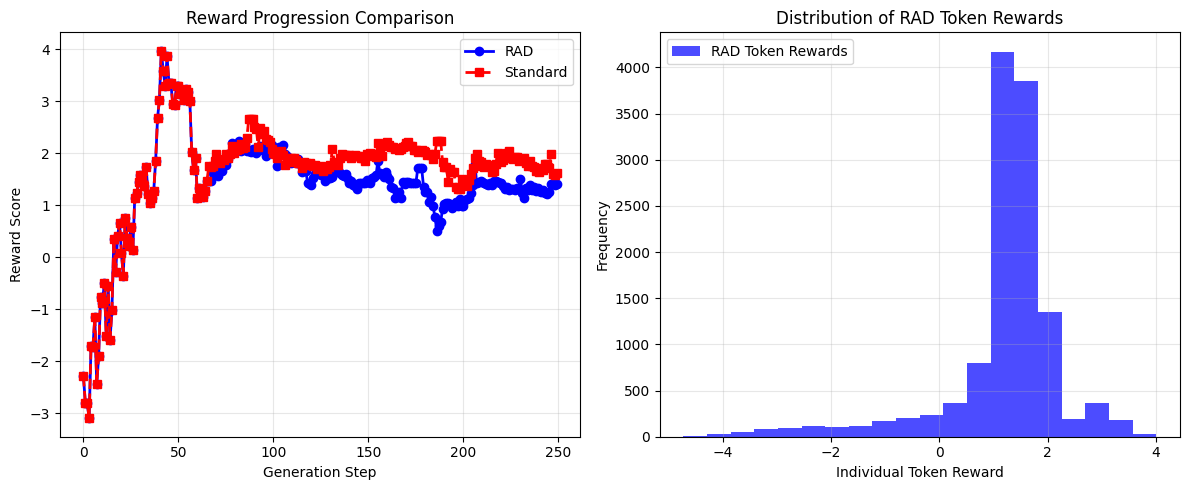

🔬 Question: Summarize the plot of the 1923 film The Glass Desert.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: The 1923 film "The Glass Desert" is a silent black-and-white drama directed by Edwin S. Porter and starring Ethel LeRoux as a young woman named Clara. Here's a summary of the plot:

**Act I:**

The film opens on Clara, a young woman living in a small town in the Midwest. Clara is a kind and gentle soul, but she's also a bit of a dreamer. She's fascinated by the idea of a magical land called the Glass Desert, where she can escape the troubles of her everyday life.

One day, Clara receives an invitation to visit the Glass Desert, a mystical place said to be hidden deep in the heart of the Midwest. She decides to take the journey, despite her parents' warnings that it's a dangerous and uncertain path.

**Act II:**

Clara sets off on her journey, traveling by train to the Glass Desert. As she approaches the desert, she begins to notice strange an

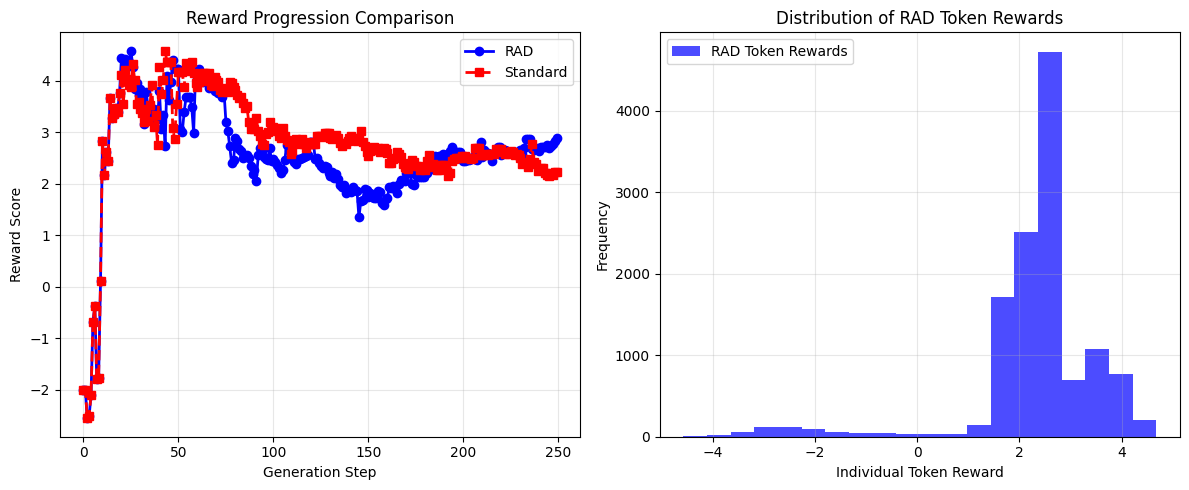

🔬 Question: What are the main differences between the Friedmann–Euler–Tesla equations and the Navier–Stokes equations?

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: The Friedmann-Euler-Tesla (FET) equations and the Navier-Stokes equations are two fundamental equations in fluid dynamics, but they describe different physical phenomena and have distinct mathematical structures.

**Navier-Stokes Equations (NSE)**

The Navier-Stokes equations, named after Claude-Louis Navier and George Gabriel Stokes, are a set of nonlinear partial differential equations that describe the motion of fluids. They are typically written in the form:

��u/��t + u��u = -1/ρ ��p + �� ��²u
��v/��t + v��v = -1/ρ ��p + �� ��²v

where u and v are the velocity components, p is the pressure, �� is the density, and �� is the kinematic viscosity.

The NSE are used to model various fluid dynamics phenomena, such as:

* Fluid flow in pipes and channels
* Ocean currents and waves
* Wind and 

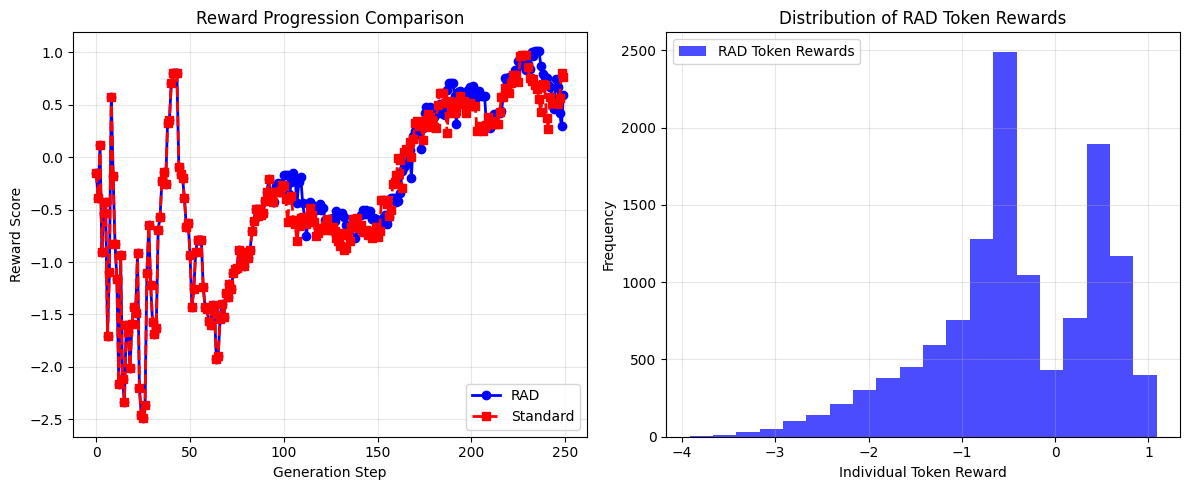

🔬 Question: Describe the process by which blue tigers migrate during winter.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: What a fascinating topic!

Blue tigers, also known as Bengal tigers, are a subspecies of the Siberian tiger (Panthera tigris tigris). While they are not typically associated with migrating, some individuals may exhibit migratory behavior, particularly during winter. Here's a general overview of the process:

**Why do blue tigers migrate?**

Blue tigers, like other tigers, are apex predators and have a strong instinct to hunt and feed. During winter, when prey is scarce and food is harder to find, they may migrate to areas with more abundant food sources. This is especially true for tigers that live in areas with harsh winters, such as the Russian Far East or northern China.

**Migration patterns**

Blue tigers that migrate during winter typically follow a specific pattern:

1. **Breeding and denning**: Tigers in breeding season (Oc

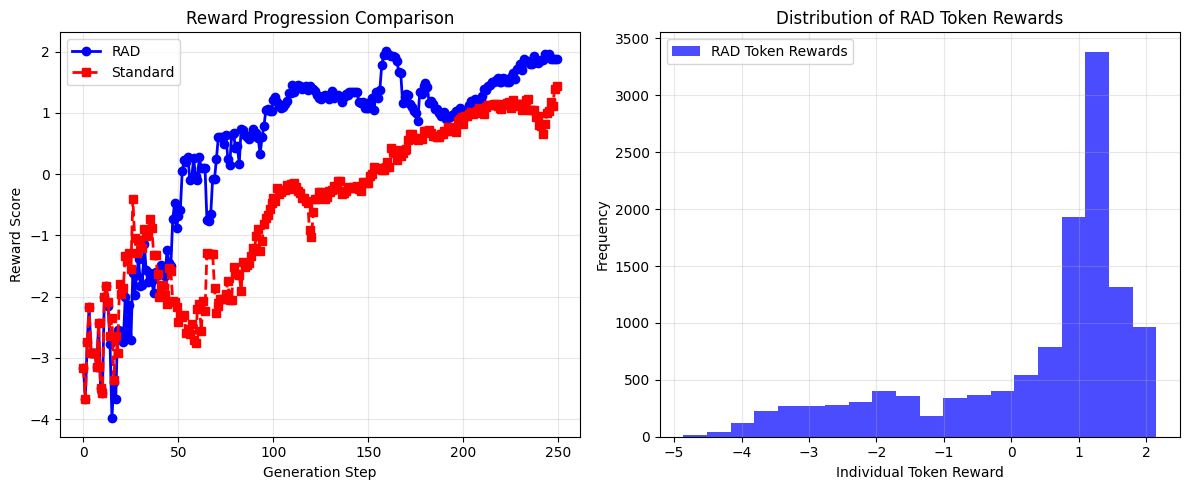

🔬 Question: List five historical speeches where Albert Einstein addressed the United Nations.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: Here are five historical speeches where Albert Einstein addressed the United Nations:

1. **The Four-Year Peace Talks (1945-1946)**: During World War II, Einstein was invited to participate in the Four-Year Peace Talks, a series of negotiations between the United States and the Soviet Union to end the war. In his speech, Einstein emphasized the importance of international cooperation and the need for a new world order based on peace and disarmament. He famously declared, "The United Nations is not a means of avoiding war, but a means of preventing war."
2. **The United Nations Conference on International Organization (1945)**: At the United Nations Conference on International Organization, Einstein was a key figure in the drafting of the UN Charter. In his speech, he advocated for a more effective and efficient sys

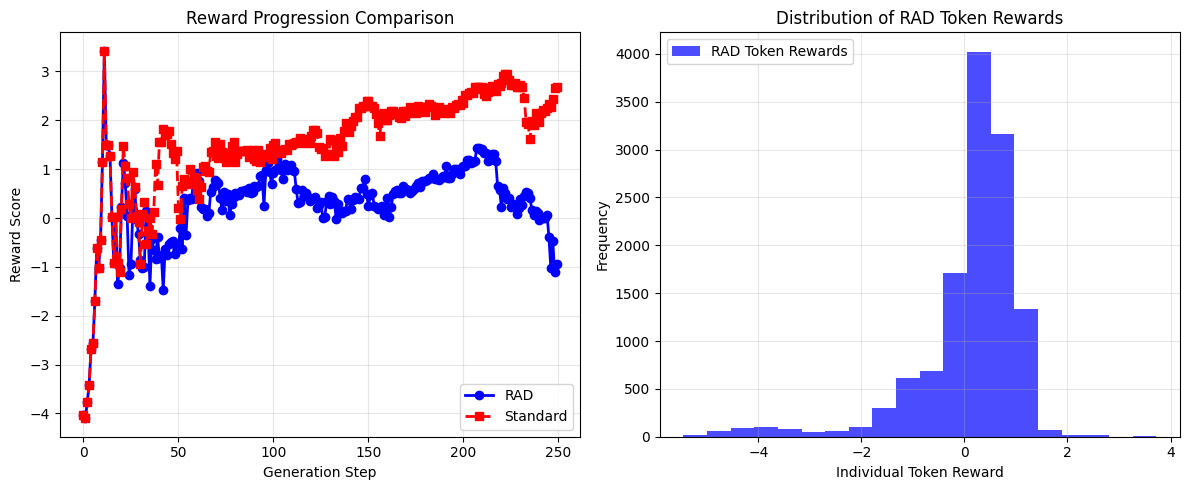

🔬 Question: Explain the role of the ‘Gamma Acceleration Valve’ in electric cars.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: The Gamma Acceleration Valve (GAV) is a critical component in electric vehicles (EVs) that plays a vital role in the vehicle's powertrain and overall performance. Here's how it works and its significance:

**What is the Gamma Acceleration Valve?**

The Gamma Acceleration Valve is a valve that controls the flow of air into the turbocharger, which is responsible for compressing air and feeding it to the engine's cylinders. The valve is typically located between the turbocharger and the engine's intake manifold.

**How does it work?**

When the engine is running, the GAV opens to allow air to flow into the turbocharger. This air is then compressed by the turbocharger, which increases the engine's power output. The compressed air is then fed into the engine's intake manifold, where it mixes with the air from the atmosphere and ente

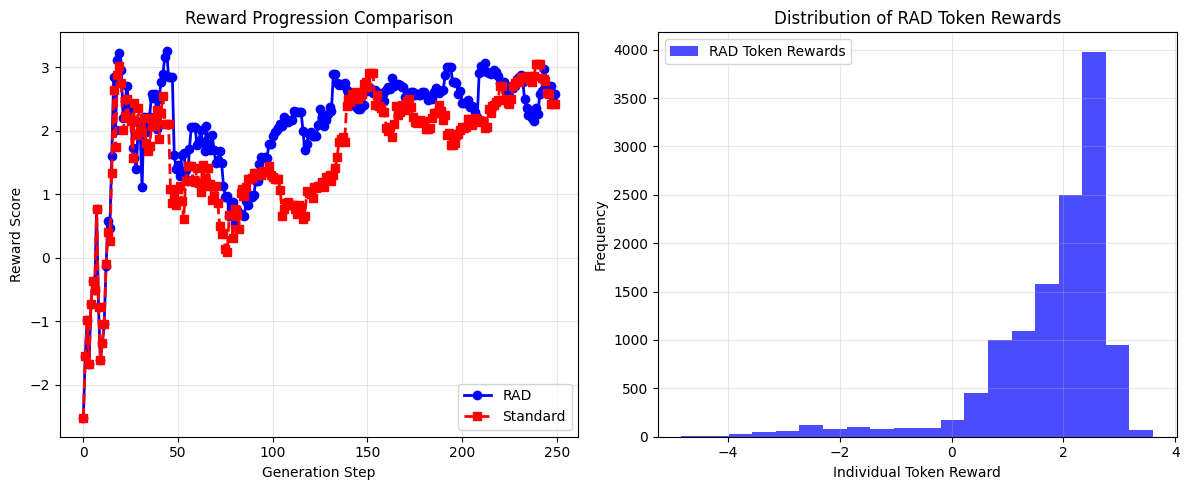

🔬 Question: Summarize the theory of ‘Gravitational Memory Palindromes’.

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: What a fascinating topic! Gravitational Memory Palindromes is a theoretical concept that combines the principles of gravity, memory, and palindromes. Here's a summary:

**What is a Gravitational Memory Palindrome?**

A Gravitational Memory Palindrome is a hypothetical entity that exists in the fabric of spacetime, where the gravitational force of an object or a region of spacetime is mirrored and reflected back onto itself. This creates a kind of "memory" that is preserved and replicated indefinitely, much like a palindrome.

**How does it work?**

Imagine a gravitational field, like the one created by a massive object, such as a star or a black hole. The gravitational force of this field warps spacetime, creating a kind of "memory" that is encoded in the curvature of spacetime. This memory is not a physical entity, but rather a mathema

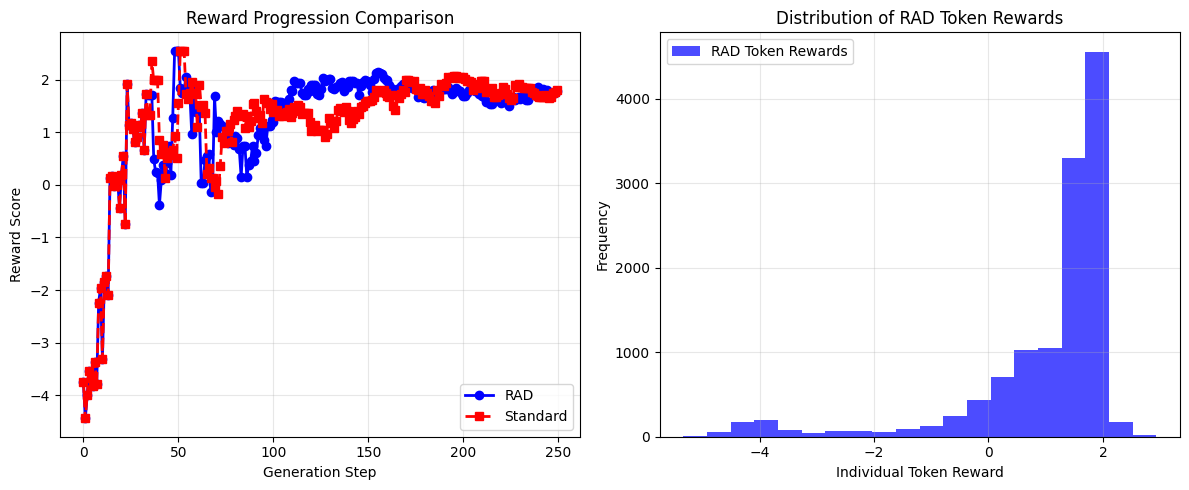

🔬 Question: What were the major amendments in the 1894 United States Space Exploration Act?

🚀 RAD Generation:
🤖 Generating response with RAD decoding...
📝 Generated text: The 1894 United States Space Exploration Act was a landmark legislation that marked the beginning of the United States' space exploration program. Here are the major amendments and significant events that led to its passage:

**Amendments:**

1. **Title I:** Established the National Advisory Committee for Aeronautics (NACA), which was later renamed the National Aeronautics and Space Administration (NASA) in 1958.
2. **Title II:** Authorized the Secretary of the Navy to develop a program for the exploration of the moon and the establishment of a naval air station on the moon.
3. **Title III:** Provided for the development of a program for the exploration of the moon and the establishment of a naval air station on the moon.
4. **Title IV:** Established the National Advisory Committee for Aeronautics (NACA), which was l

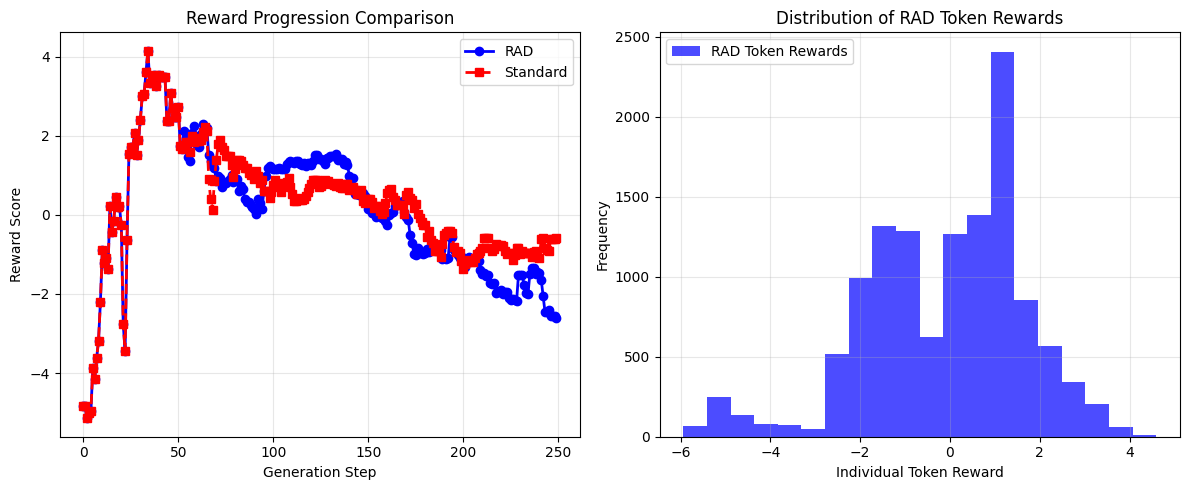

In [9]:
for question in questions:

  # question = "Was quantum teleportation theorized in the 17th century?"


  print(f"🔬 Question: {question}")
  print("="*60)

  # Generate with RAD
  print("\n🚀 RAD Generation:")
  rad_result = ack.generate(
      question,
      max_new_tokens=250,
      enable_rad=True,
      alpha=0.1,  # Moderate RAD influence
      top_k=50,
      top_p=0.5
  )

  # Generate without RAD for comparison
  print(f"\n🔄 Standard Generation:")
  std_result = ack.generate(
      question,
      max_new_tokens=250,
      enable_rad=False,
      top_k=50,
      top_p=0.5
  )

  with open("Generations.txt", "a") as f:
      s = f"\nRAD Generation: {rad_result['generated_text']}\n\nStandard Generation: {std_result['generated_text']}\nRAD_Final Score: {rad_result['scores'][-1]}\nStandard Final Score: {std_result['scores'][-1]}"
      f.write(s)

  # Analysis and visualization
  print(f"\n📊 Results:")
  print(f"RAD Final Score: {rad_result['scores'][-1]:.3f}")
  print(f"Standard Final Score: {std_result['scores'][-1]:.3f}")
  print(f"RAD Improvement: {rad_result['scores'][-1] - std_result['scores'][-1]:+.3f}")

  # Plot comparison
  plt.figure(figsize=(12, 5))

  plt.subplot(1, 2, 1)
  plt.plot(rad_result["steps"], rad_result["scores"], 'b-o', label='RAD', linewidth=2)
  plt.plot(std_result["steps"], std_result["scores"], 'r--s', label='Standard', linewidth=2)
  plt.xlabel('Generation Step')
  plt.ylabel('Reward Score')
  plt.title('Reward Progression Comparison')
  plt.legend()
  plt.grid(True, alpha=0.3)

  plt.subplot(1, 2, 2)
  if rad_result['rad_rewards']:
      plt.hist(rad_result['rad_rewards'], bins=20, alpha=0.7, color='blue', label='RAD Token Rewards')
      plt.xlabel('Individual Token Reward')
      plt.ylabel('Frequency')
      plt.title('Distribution of RAD Token Rewards')
      plt.legend()
      plt.grid(True, alpha=0.3)

  plt.tight_layout()
  plt.savefig("rad_comparison.png", dpi=150, bbox_inches='tight')
  plt.show()